# Beer Dataset

In [1]:
#importing the libraries...
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools
import numpy as np
from statsmodels.tsa.stattools import adfuller

In [2]:
beer = pd.read_csv('beer.csv')
beer.head()

,OzBeer
0,284.4
1,212.8
2,226.9
3,308.4
4,262.0


In [3]:
beer.shape

(72, 1)

In [4]:
beer.columns

Index(['OzBeer  '], dtype='object')

In [5]:
index = pd.Index(range(1,72))
print(index)

RangeIndex(start=1, stop=72, step=1)


In [6]:
beer = pd.DataFrame(beer, index=index)

In [7]:
beer.index.names = ['Month']

In [8]:
beer.tail()             

,OzBeer
Month,
67,506.1
68,458.4
69,387.4
70,426.9
71,525.0


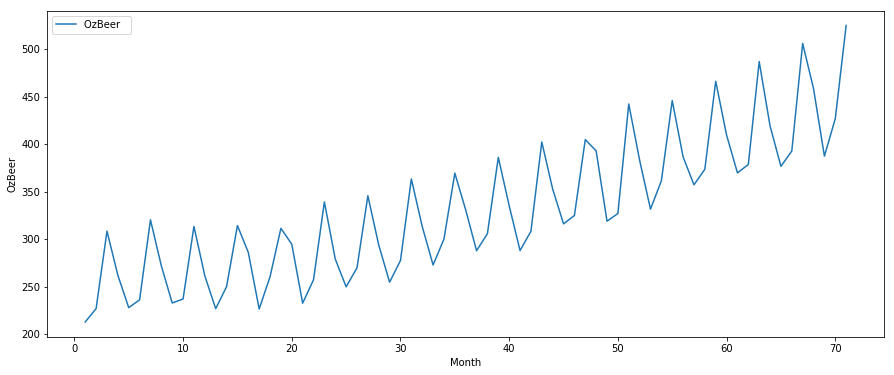

In [9]:
#plotting the time series...
beer.plot(figsize=(15,6))
plt.xlabel('Month')
plt.ylabel('OzBeer')
plt.show()

### Checking for trend & seasonality in the data...

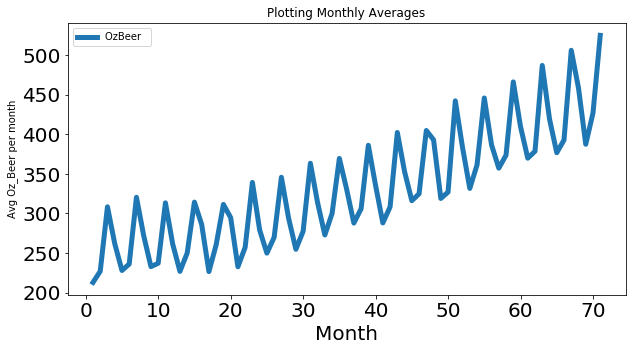

In [10]:
oz_beer = beer[['OzBeer  ']]
oz_beer.rolling(1).mean().plot(figsize=(10,5),linewidth=5,fontsize=20)
plt.xlabel('Month',fontsize = 20)
plt.ylabel('Avg Oz_Beer per month')
plt.title('Plotting Monthly Averages')
plt.legend()

Here we can clearly see that data has both trend & seasonality...

### Splitting the data into training & test...

In [11]:
train = oz_beer
test = oz_beer[50:]

In [12]:
train.head()

,OzBeer
Month,
1,212.8
2,226.9
3,308.4
4,262.0
5,227.9


In [13]:
train.columns

Index(['OzBeer  '], dtype='object')

In [14]:
test.head()

,OzBeer
Month,
51,442.3
52,383.1
53,331.6
54,361.4
55,445.9


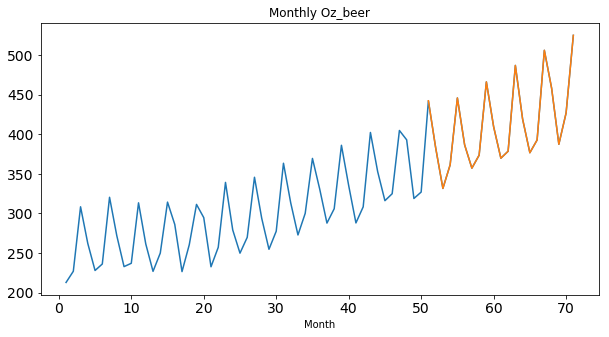

In [15]:
train['OzBeer  '].plot(figsize=(10,5),title='Monthly Oz_beer',fontsize=14)
test['OzBeer  '].plot(figsize=(10,5),title='Monthly Oz_beer',fontsize=14)

### Hypothesis testing for stationarity...

In [16]:
#Checking for stationarity...
#Null hypothesis = Data is not Stationery
#Alternate hypothesis = Data is Stationery
result = adfuller(train['OzBeer  '],autolag='AIC')
print('ADF Statistic : %f'%result[0])
print('p-value:%f'%result[1])
print('AIC:%f'%result[5])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s:%.3f'%(key,value))

ADF Statistic : 3.269043
p-value:1.000000
AIC:440.707768
Critical Values:
	1%:-3.541
	5%:-2.909
	10%:-2.592


i.e. Data is not stationery which we saw in the above graphs also..

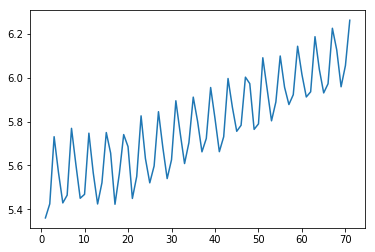

In [17]:
#Taking log to stabilize the increasing variance
log_train = np.log(train['OzBeer  '])
plt.plot(log_train) 

In [18]:
log_train1 = pd.DataFrame(log_train)

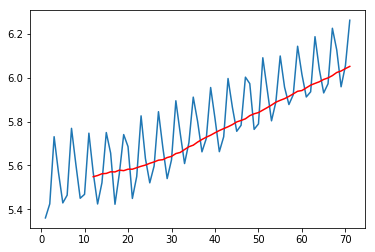

In [19]:
#when we take log data becomes linear not stationery
#moving average plot of log data
moving_avg = log_train.rolling(12).mean()
plt.plot(log_train)
plt.plot(moving_avg, color='red')

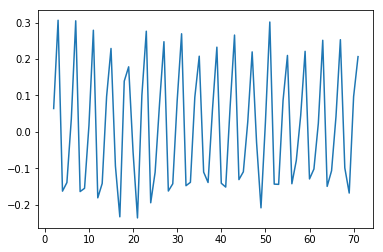

In [20]:
#taking the differences of the data & checking for the stationerity

log_train_diff = log_train - log_train.shift()
plt.plot(log_train_diff)

In [21]:
#Drop the na values
log_train_diff.dropna(inplace=True)

In [22]:
#again testing for Stationery...
result = adfuller(log_train_diff,autolag='AIC')
print('ADF Statistic : %f'%result[0])
print('p-value:%f'%result[1])
print('AIC:%f'%result[5])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s:%.3f'%(key,value))

ADF Statistic : -3.094685
p-value:0.026949
AIC:-233.571776
Critical Values:
	1%:-3.537
	5%:-2.908
	10%:-2.591


i.e. Data is stationery now..have a look at changed p-value..

In [23]:
#ACF & PACF plots :
from statsmodels.tsa.stattools import acf,pacf
lag_acf = acf(log_train_diff, nlags = 20)
lag_pacf = pacf(log_train_diff, nlags =20, method='ols')

Text(0.5,1,'Autocorrelation Function')

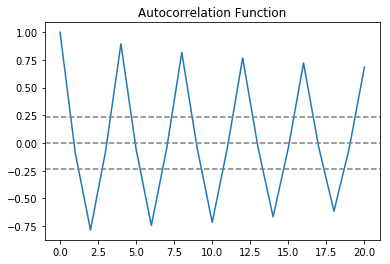

In [24]:
#plot ACF & PACF...

plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(log_train_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(log_train_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

Text(0.5,1,'Partial Autocorrelation Function')

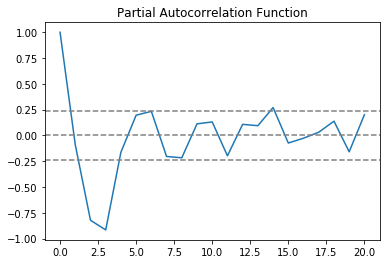

In [25]:
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(log_train_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(log_train_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

In [26]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

-87.785431305575


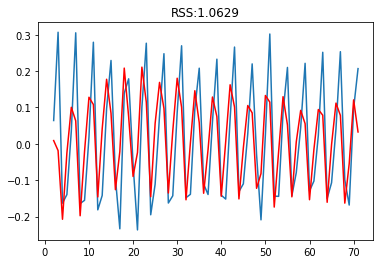

In [27]:
model = ARIMA(log_train, order =(1,1,1))
results_ARIMA = model.fit(disp=-1)
plt.plot(log_train_diff)
plt.plot(results_ARIMA.fittedvalues,color='red')
plt.title('RSS:%.4f'%sum((results_ARIMA.fittedvalues-log_train_diff)**2))
print(results_ARIMA.aic)

-95.07411335922825


/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


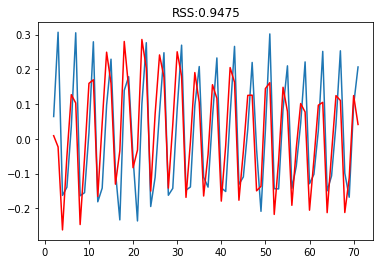

In [28]:
model = ARIMA(log_train, order =(1,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(log_train_diff)
plt.plot(results_ARIMA.fittedvalues,color='red')
plt.title('RSS:%.4f'%sum((results_ARIMA.fittedvalues-log_train_diff)**2))
print(results_ARIMA.aic)

-179.39544786944413


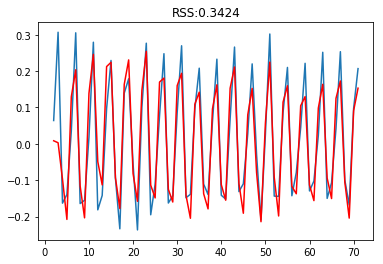

In [29]:
model = ARIMA(log_train, order =(2,1,1))
results_ARIMA = model.fit(disp=-1)
plt.plot(log_train_diff)
plt.plot(results_ARIMA.fittedvalues,color='red')
plt.title('RSS:%.4f'%sum((results_ARIMA.fittedvalues-log_train_diff)**2))
print(results_ARIMA.aic)

-257.82705308579006


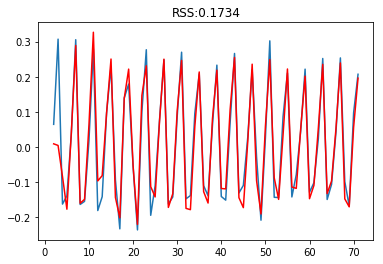

In [30]:
model = ARIMA(log_train, order =(3,1,1))
results_ARIMA = model.fit(disp=-1)
plt.plot(log_train_diff)
plt.plot(results_ARIMA.fittedvalues,color='red')
plt.title('RSS:%.4f'%sum((results_ARIMA.fittedvalues-log_train_diff)**2))
print(results_ARIMA.aic)

-257.82705308579006


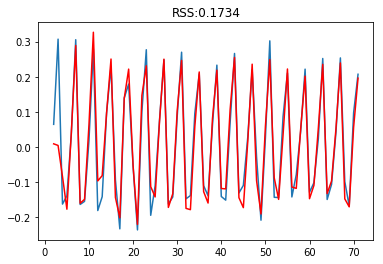

In [31]:
model_final = ARIMA(log_train, order =(3,1,2))
results_ARIMA1 = model.fit(disp=-1)
plt.plot(log_train_diff)
plt.plot(results_ARIMA1.fittedvalues,color='red')
plt.title('RSS:%.4f'%sum((results_ARIMA1.fittedvalues-log_train_diff)**2))
print(results_ARIMA1.aic)

In [32]:
#we will take the model 5 with lowest AIC value and fit the arima model on that
predictions_ARIMA_diff = pd.Series(results_ARIMA1.fittedvalues,  copy = True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

In [33]:
#Antilog
predictions_ARIMA_log = pd.Series(log_train1['OzBeer  '].ix[1], index = log_train.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value = 0)
predictions_ARIMA_log.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


Month
1    5.360353
2    5.368995
3    5.373047
4    5.288528
5    5.110920
dtype: float64

In [34]:
predictions_ARIMA  = np.exp(predictions_ARIMA_log)

array([473.50501818, 401.37609626, 443.75510136, 541.24523754,
       489.61218903, 416.03741266, 461.03946389, 558.22997439,
       506.12335598, 431.36880154, 478.80724701, 575.93158758,
       523.09250468, 447.3641722 , 497.10529403, 594.33850095,
       540.56607091, 464.02446294, 515.97499304, 613.44763783,
       558.5849156 , 481.35612942, 535.45373013, 633.26252573])

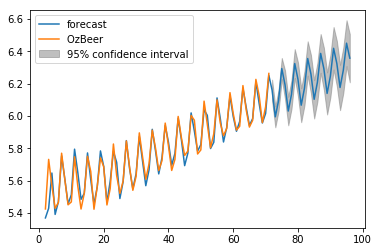

In [35]:
#predicted values with plot...
results_ARIMA1.plot_predict(1,95)
re= results_ARIMA.forecast(steps = 24)
re[0]
result_f = np.exp(re[0])
result_f

### Applying holt winters...

/anaconda3/lib/python3.7/site-packages/matplotlib/legend.py:640: UserWarning: Unrecognized location "Best". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


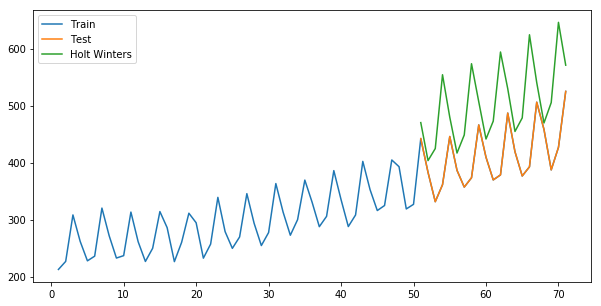

In [47]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
y_hat_avg = test.copy()
fit2 = ExponentialSmoothing(np.asarray(train['OzBeer  ']),trend="mul",seasonal="mul",seasonal_periods=12).fit(optimized=True)
y_hat_avg['Holt Winters'] = fit2.forecast(len(test))
plt.figure(figsize=(10,5))
plt.plot(train['OzBeer  '], label = 'Train')
plt.plot(test['OzBeer  '], label = 'Test')
plt.plot(y_hat_avg['Holt Winters'],label = 'Holt Winters')
plt.legend(loc = 'Best')
plt.show()


In [45]:
y_hat_avg1 = fit2.predict(start = 1, end = 96)

In [46]:
y_hat_avg1

array([231.85592154, 299.18437243, 258.72715084, 223.92269713,
       240.36617923, 304.49236127, 270.28890203, 234.64510098,
       249.85261289, 309.21964005, 274.81836907, 232.24995422,
       241.52300503, 314.83595749, 270.63675663, 236.22363542,
       250.80047968, 321.03073917, 280.52752132, 245.31759387,
       258.82613319, 322.74065173, 288.91443656, 245.10003643,
       257.4068766 , 337.294103  , 292.34693604, 253.45909469,
       272.19882944, 348.33703363, 309.81856751, 270.20935732,
       289.79403927, 366.51821259, 327.59269657, 281.99303176,
       298.33220491, 391.91355559, 339.15623575, 294.60220944,
       316.15070568, 402.58254563, 355.86795444, 309.53480899,
       332.99870548, 416.5851586 , 369.37794397, 320.86817166,
       337.59593497, 438.05382757, 379.97233547, 330.75935589,
       356.28135127, 457.02448707, 402.31531064, 347.75884461,
       374.19428254, 469.88597076, 418.29811303, 357.406833  ,
       378.35873366, 493.71139478, 426.2942524 , 369.01